In [1]:
%pip install pandas
%pip install numpy
%pip install datetime
%pip install matplotlib
%pip install sklearn
%pip install skforecast

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [3]:
#Load and preprocess data
file = pd.read_csv('./data.csv')
file['DateTime'] = pd.to_datetime(file['DateTime'])
file.set_index('DateTime', inplace=True)
file = file[file['SM_10'].notna()].loc[file[file['SM_10'].notna()].index[0]:]
# Uncomment these lines to apply additional data preprocessing
# file['SM_10'] = np.where(file['SM_10'] < 20, np.nan, file['SM_10'])
# file['SM_10'] = np.where(file['SM_10'] > 100, np.nan, file['SM_10'])

file_mean = file.resample('H').mean()
file_sum = file.resample('H').sum()

data_train = file_sum  # You can choose between file_mean and file_sum based on your preference
data_test = None  # Define your test data accordingly if needed

In [4]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 36 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-26 20:10:27 
Last fit date: None 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [5]:
#The model trains but it needs to be tuned

# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # This value will be replaced in the grid search
             )

param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['SM_10'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.693e+00, tolerance: 1.988e+00
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+01, tolerance: 1.988e+00
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 498.6606057813761



/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.396e+02, tolerance: 3.979e+00
  model = cd_fast.enet_coordinate_descent(


In [6]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,alpha
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1e-05},498.660606,0.000010
0,"[1, 2, 3, 4, 5]",{'alpha': 1e-05},498.911009,0.000010
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},499.527476,0.000129
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1e-05},500.076659,0.000010
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.0001291549665014884},500.245607,0.000129


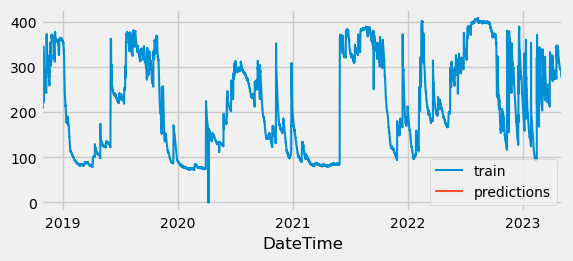

In [8]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['SM_10'].plot(ax=ax, label='train')
#data_test['SM_10'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")